## Introduction
In this project, we'll be classifying the sentiment of sentences from the Rotten tomatoes dataset.The Rotten Tomatoes movie review dataset is a corpus of movie reviews used for sentiment analysis, originally collected by Pang and Lee [1]. In their work on sentiment treebanks, Socher et al. [2] used Amazon's Mechanical Turk to create fine-grained labels for all parsed phrases in the corpus. This competition presents a chance to benchmark your sentiment-analysis ideas on the Rotten Tomatoes dataset. You are asked to label phrases on a scale of five values: negative, somewhat negative, neutral, somewhat positive, positive. Obstacles like sentence negation, sarcasm, terseness, language ambiguity, and many others make this task very challenging.
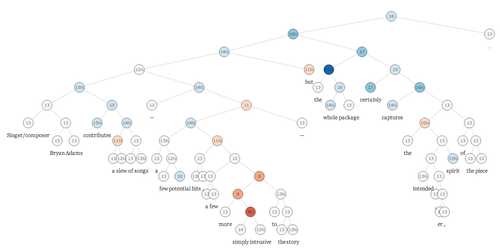
We'll be combining LSTM-CNN Models for our implementation and here a brief explaination for each network.

## CNNs
Convolutional Neural Networks (CNNs) are networks initially created for image-related tasks that can learn to capture specific features regardless of locality.

For a more concrete example of that, imagine we use CNNs to distinguish pictures of Cars vs. pictures of Dogs. Since CNNs learn to capture features regardless of where these might be, the CNN will learn that cars have wheels, and every time it sees a wheel, regardless of where it is on the picture, that feature will activate.

In our particular case, it could capture a negative phrase such as "don't like" regardless of where it happens in the tweet.

* I don't like watching those types of films
* That's the one thing I really don't like.
* I saw the movie, and I don't like how it ended.

## N-Grams 
An N-gram is a sequence of N words: a 2-gram (or bi-gram) is a two-word sequence of words like “please turn”, “turn your”, or ”your homework”, and a 3-gram (or tri-gram) is a three-word sequence of words like “please turn your”, or “turn your homework”.

Whether estimating probabilities of next words or of whole sequences, the N-gram model is one of the most important tools in speech and language processing.


## LSTMs
Long-Term Short Term Memory (LSTMs) are a type of network that has a memory that "remembers" previous data from the input and makes decisions based on that knowledge. These networks are more directly suited for written data inputs, since each word in a sentence has meaning based on the surrounding words (previous and upcoming words).

In our particular case, it is possible that an LSTM could allow us to capture changing sentiment in a tweet. For example, a sentence such as: At first I loved it, but then I ended up hating it. has words with conflicting sentiments that would end-up confusing a simple Feed-Forward network. The LSTM, on the other hand, could learn that sentiments expressed towards the end of a sentence mean more than those expressed at the start.

## Importing Libraries

In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from nltk.tokenize import TweetTokenizer
import datetime
import LightGBM as lgb
from scipy import stats
from scipy.sparse import hstack, csr_matrix
from sklearn.model_selection import train_test_split, cross_val_score
from wordcloud import WordCloud
from collections import Counter
from nltk.corpus import stopwords
from nltk.util import ngrams
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
pd.set_option('max_colwidth',400)

## Data Exploration

In [29]:
train = pd.read_csv('all/train.tsv', sep="\t")
test = pd.read_csv('all/test.tsv', sep="\t")
sub = pd.read_csv('all/sampleSubmission.csv', sep=",")

In [30]:
train.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,"A series of escapades demonstrating the adage that what is good for the goose is also good for the gander , some of which occasionally amuses but none of which amounts to much of a story .",1
1,2,1,A series of escapades demonstrating the adage that what is good for the goose,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [31]:
test.head()

,PhraseId,SentenceId,Phrase
0,156061,8545,An intermittently pleasing but mostly routine effort .
1,156062,8545,An intermittently pleasing but mostly routine effort
2,156063,8545,An
3,156064,8545,intermittently pleasing but mostly routine effort
4,156065,8545,intermittently pleasing but mostly routine


In [32]:
class_count = train['Sentiment'].value_counts()
class_count

2    79582
3    32927
1    27273
4     9206
0     7072
Name: Sentiment, dtype: int64

In [33]:
test.head()

,PhraseId,SentenceId,Phrase
0,156061,8545,An intermittently pleasing but mostly routine effort .
1,156062,8545,An intermittently pleasing but mostly routine effort
2,156063,8545,An
3,156064,8545,intermittently pleasing but mostly routine effort
4,156065,8545,intermittently pleasing but mostly routine


## The sentiment labels are:
0 - negative 1 - somewhat negative 2 - neutral 3 - somewhat positive 4 - positive

Text(0,0.5,'Number of reviews')

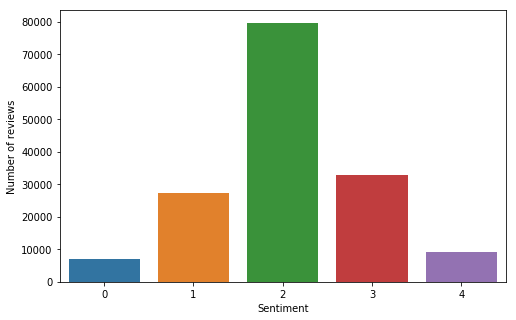

In [36]:
x = np.array(class_count.index)
y = np.array(class_count.values)
plt.figure(figsize=(8,5))
sns.barplot(x,y)
plt.xlabel("Sentiment")
plt.ylabel("Number of reviews")

In [37]:
print('Number of sentences in training set:',len(train['SentenceId'].unique()))
print('Number of sentences in test set:',len(test['SentenceId'].unique()))
print('Average words per sentence in train:',train.groupby('SentenceId')['Phrase'].count().mean())
print('Average words per sentence in test:',test.groupby('SentenceId')['Phrase'].count().mean())

Number of sentences in training set: 8529
Number of sentences in test set: 3310
Average words per sentence in train: 18.297572986282095
Average words per sentence in test: 20.027794561933536


In [38]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
stopwords = set(STOPWORDS)

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='black',
        stopwords=stopwords,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
).generate(str(data))

    fig = plt.figure(1, figsize=(15, 15))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

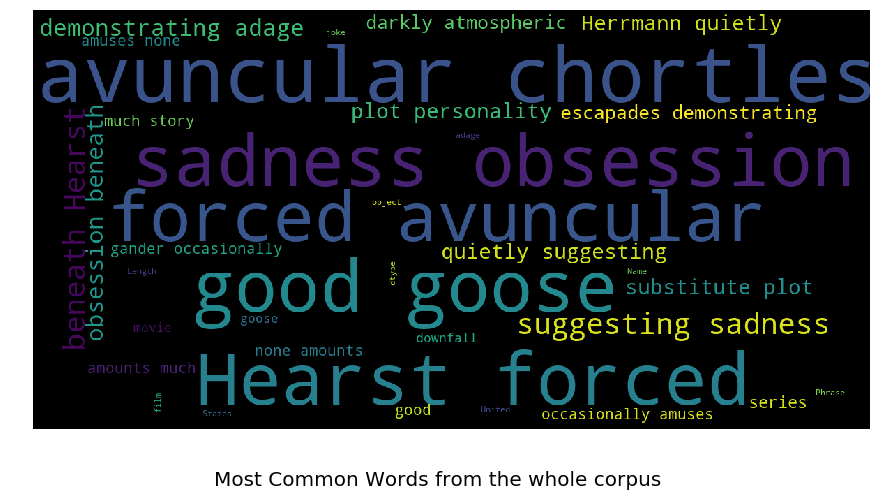

In [39]:
show_wordcloud(train['Phrase'],'Most Common Words from the whole corpus')

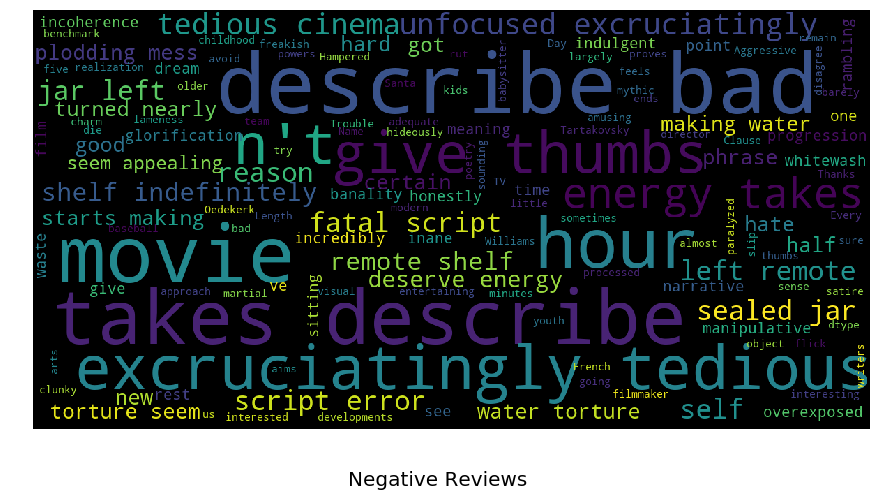

In [40]:
show_wordcloud(train[train['Sentiment'] == 0]['Phrase'],'Negative Reviews')

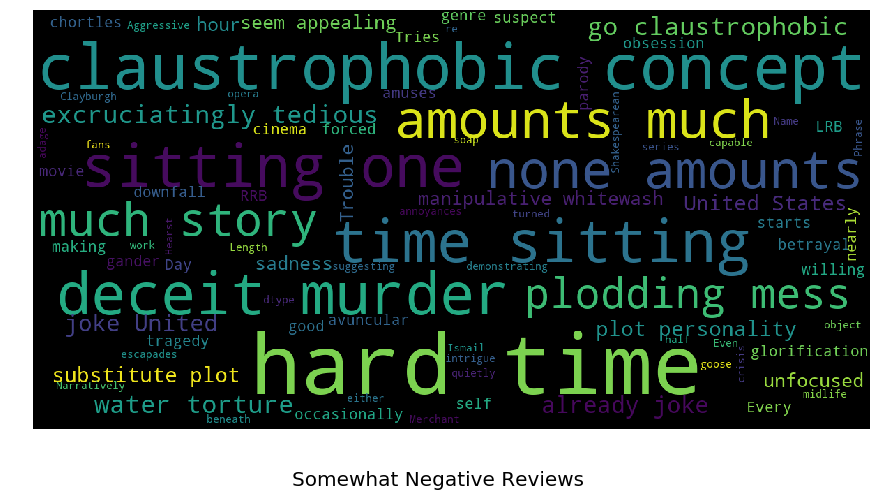

In [41]:
show_wordcloud(train[train['Sentiment'] == 1]['Phrase'],'Somewhat Negative Reviews')

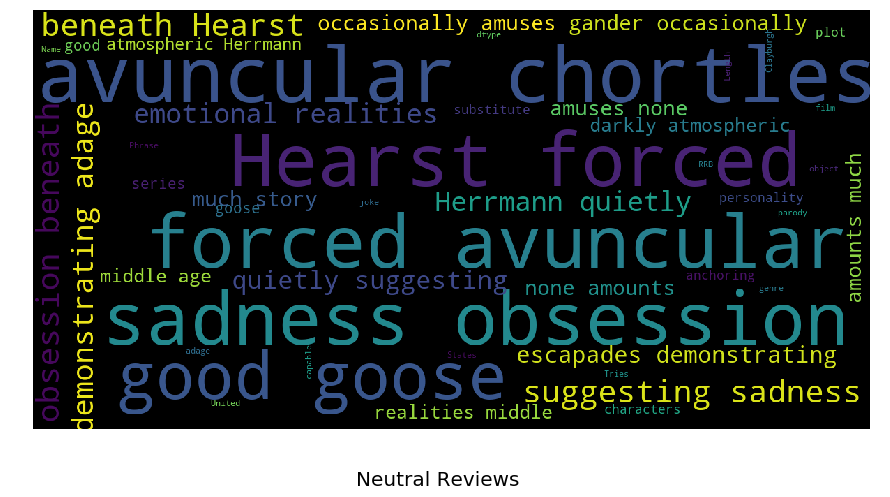

In [42]:
show_wordcloud(train[train['Sentiment'] == 2]['Phrase'],'Neutral Reviews')

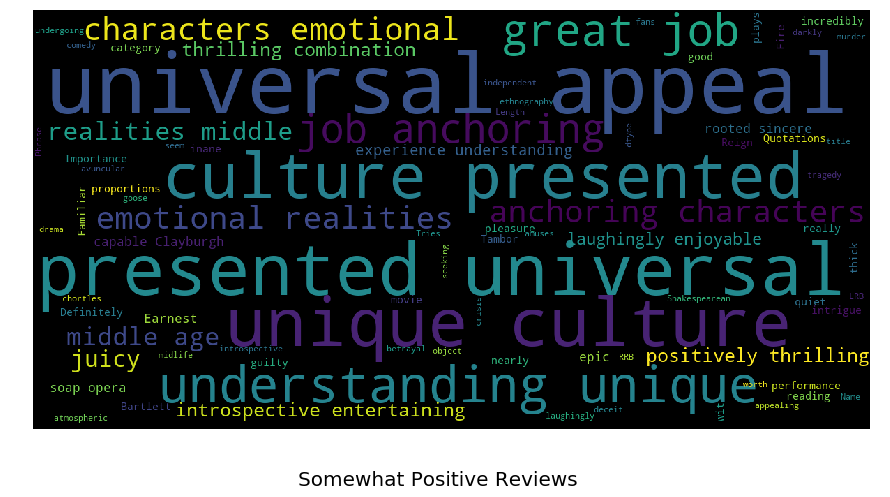

In [43]:
show_wordcloud(train[train['Sentiment'] == 3]['Phrase'],'Somewhat Positive Reviews')

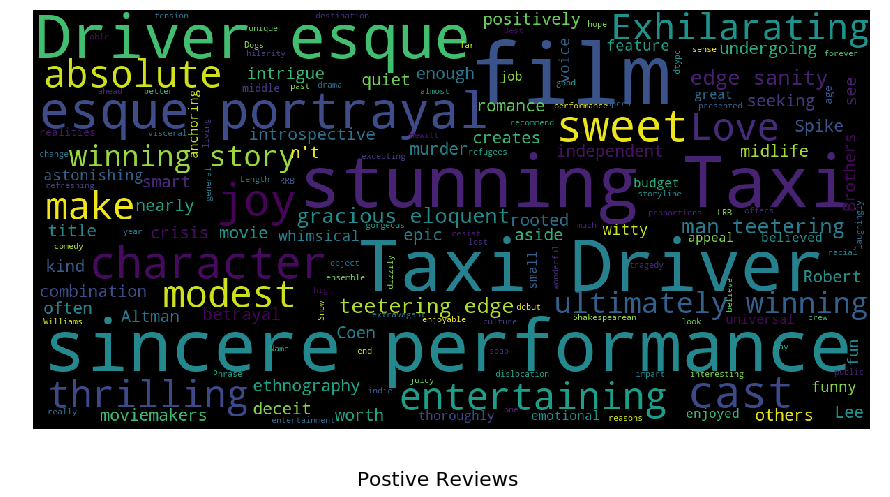

In [44]:
show_wordcloud(train[train['Sentiment'] == 4]['Phrase'],'Postive Reviews')

In [45]:
from sklearn.feature_extraction.text import CountVectorizer

cv1 = CountVectorizer()
cv1.fit(train["Phrase"])

cv2 = CountVectorizer()
cv2.fit(test["Phrase"])

print("Train Set Vocabulary Size:", len(cv1.vocabulary_))
print("Test Set Vocabulary Size:", len(cv2.vocabulary_))
print("Number of Words that occur in both:", len(set(cv1.vocabulary_.keys()).intersection(set(cv2.vocabulary_.keys()))))

Train Set Vocabulary Size: 15240
Test Set Vocabulary Size: 9546
Number of Words that occur in both: 7057


## Machine Learning

In [46]:
# N-Grams
vectorizer = TfidfVectorizer(ngram_range=(1, 3), tokenizer=tokenizer.tokenize)
full_text = list(train['Phrase'].values) + list(test['Phrase'].values)
vectorizer.fit(full_text)
train_vectorized = vectorizer.transform(train['Phrase'])
test_vectorized = vectorizer.transform(test['Phrase'])

In [47]:
y = train['Sentiment']

In [48]:
from sklearn.model_selection import train_test_split
x_train , x_val, y_train , y_val = train_test_split(train_vectorized,y,test_size = 0.2)

## Training Logistic Reagression model and an SVM.

In [51]:

lr = LogisticRegression()
ovr = OneVsRestClassifier(lr)
ovr.fit(x_train,y_train)
print(classification_report( ovr.predict(x_val) , y_val))
print(accuracy_score( ovr.predict(x_val) , y_val ))

             precision    recall  f1-score   support

          0       0.18      0.67      0.28       381
          1       0.33      0.55      0.41      3218
          2       0.91      0.65      0.75     22297
          3       0.42      0.60      0.50      4699
          4       0.22      0.67      0.34       617

avg / total       0.75      0.63      0.67     31212

0.6301102140202486


In [52]:
svm = LinearSVC()
svm.fit(x_train,y_train)
print(classification_report( svm.predict(x_val) , y_val))
print(accuracy_score( svm.predict(x_val) , y_val ))

             precision    recall  f1-score   support

          0       0.39      0.52      0.45      1062
          1       0.51      0.55      0.53      5044
          2       0.81      0.73      0.76     17684
          3       0.52      0.58      0.55      5948
          4       0.42      0.53      0.47      1474

avg / total       0.67      0.65      0.66     31212

0.6527617582980905


## Ensembling

In [53]:
estimators = [ ('svm',svm) , ('ovr' , ovr) ]
clf = VotingClassifier(estimators , voting='hard')
clf.fit(x_train,y_train)
print(classification_report( clf.predict(x_val) , y_val))
print(accuracy_score( clf.predict(x_val) , y_val ))

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


             precision    recall  f1-score   support

          0       0.39      0.52      0.45      1074
          1       0.52      0.54      0.53      5202
          2       0.86      0.68      0.76     19867
          3       0.41      0.62      0.49      4476
          4       0.22      0.68      0.33       593

avg / total       0.71      0.64      0.66     31212

0.6437908496732027


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [54]:
from keras.utils import to_categorical
target=train.Sentiment.values
y=to_categorical(target)
y

array([[0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.]], dtype=float32)

In [62]:
max_features = 13000
max_words = 50
batch_size = 128
epochs = 10
num_classes=5

In [56]:
from sklearn.model_selection import train_test_split
X_train , X_val , Y_train , Y_val = train_test_split(train['Phrase'],y,test_size = 0.20)

In [57]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense,GRU,LSTM,Embedding
from keras.optimizers import Adam
from keras.layers import SpatialDropout1D,Dropout,Bidirectional,Conv1D,GlobalMaxPooling1D,MaxPooling1D,Flatten
from keras.callbacks import ModelCheckpoint, TensorBoard, Callback, EarlyStopping

In [58]:
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(X_train))
X_train = tokenizer.texts_to_sequences(X_train)
X_val = tokenizer.texts_to_sequences(X_val)

In [59]:
X_test = tokenizer.texts_to_sequences(test['Phrase'])
X_test =pad_sequences(X_test, maxlen=max_words)


In [60]:
X_train =pad_sequences(X_train, maxlen=max_words)
X_val = pad_sequences(X_val, maxlen=max_words)
X_test =pad_sequences(X_test, maxlen=max_words)

In [61]:
model_GRU=Sequential()
model_GRU.add(Embedding(max_features,100,mask_zero=True))
model_GRU.add(GRU(64,dropout=0.4,return_sequences=True))
model_GRU.add(GRU(32,dropout=0.5,return_sequences=False))
model_GRU.add(Dense(num_classes,activation='softmax'))
model_GRU.compile(loss='categorical_crossentropy',optimizer=Adam(lr = 0.001),metrics=['accuracy'])
model_GRU.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 100)         1300000   
_________________________________________________________________
gru_1 (GRU)                  (None, None, 64)          31680     
_________________________________________________________________
gru_2 (GRU)                  (None, 32)                9312      
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 165       
Total params: 1,341,157
Trainable params: 1,341,157
Non-trainable params: 0
_________________________________________________________________


In [63]:
%%time
history1=model_GRU.fit(X_train, Y_train, validation_data=(X_val, Y_val),epochs=epochs, batch_size=batch_size, verbose=1)

Train on 124848 samples, validate on 31212 samples
Epoch 1/10


InvalidArgumentError: No OpKernel was registered to support Op 'CudnnRNN' with these attrs.  Registered devices: [CPU], Registered kernels:
  <no registered kernels>

	 [[Node: bidirectional_1/CudnnRNN_1 = CudnnRNN[T=DT_FLOAT, direction="unidirectional", dropout=0, input_mode="linear_input", is_training=true, rnn_mode="gru", seed=87654321, seed2=0](bidirectional_1/transpose_2, bidirectional_1/ExpandDims_3, bidirectional_1/Const_1, bidirectional_1/concat_1)]]

Caused by op 'bidirectional_1/CudnnRNN_1', defined at:
  File "/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/anaconda3/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 127, in start
    self.asyncio_loop.run_forever()
  File "/anaconda3/lib/python3.6/asyncio/base_events.py", line 421, in run_forever
    self._run_once()
  File "/anaconda3/lib/python3.6/asyncio/base_events.py", line 1431, in _run_once
    handle._run()
  File "/anaconda3/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/anaconda3/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 117, in _handle_events
    handler_func(fileobj, events)
  File "/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/anaconda3/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/anaconda3/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2662, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2785, in _run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2903, in run_ast_nodes
    if self.run_code(code, result):
  File "/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-27-67225eb9c3bd>", line 1, in <module>
    model1 = build_model1(lr = 1e-3, lr_d = 1e-10, units = 64, spatial_dr = 0.3, kernel_size1=3, kernel_size2=2, dense_units=32, dr=0.1, conv_size=32)
  File "<ipython-input-26-66b27be7f013>", line 11, in build_model1
    x_gru = Bidirectional(CuDNNGRU(units, return_sequences = True))(x1)
  File "/anaconda3/lib/python3.6/site-packages/keras/layers/wrappers.py", line 426, in __call__
    return super(Bidirectional, self).__call__(inputs, **kwargs)
  File "/anaconda3/lib/python3.6/site-packages/keras/engine/base_layer.py", line 460, in __call__
    output = self.call(inputs, **kwargs)
  File "/anaconda3/lib/python3.6/site-packages/keras/layers/wrappers.py", line 505, in call
    y_rev = self.backward_layer.call(inputs, **kwargs)
  File "/anaconda3/lib/python3.6/site-packages/keras/layers/cudnn_recurrent.py", line 90, in call
    output, states = self._process_batch(inputs, initial_state)
  File "/anaconda3/lib/python3.6/site-packages/keras/layers/cudnn_recurrent.py", line 297, in _process_batch
    is_training=True)
  File "/anaconda3/lib/python3.6/site-packages/tensorflow/contrib/cudnn_rnn/python/ops/cudnn_rnn_ops.py", line 1623, in __call__
    seed=self._seed)
  File "/anaconda3/lib/python3.6/site-packages/tensorflow/contrib/cudnn_rnn/python/ops/cudnn_rnn_ops.py", line 1012, in _cudnn_rnn_no_input_c
    direction, dropout, seed, name)
  File "/anaconda3/lib/python3.6/site-packages/tensorflow/contrib/cudnn_rnn/python/ops/cudnn_rnn_ops.py", line 926, in _cudnn_rnn
    name=name)
  File "/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gen_cudnn_rnn_ops.py", line 115, in cudnn_rnn
    is_training=is_training, name=name)
  File "/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3392, in create_op
    op_def=op_def)
  File "/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1718, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

InvalidArgumentError (see above for traceback): No OpKernel was registered to support Op 'CudnnRNN' with these attrs.  Registered devices: [CPU], Registered kernels:
  <no registered kernels>

	 [[Node: bidirectional_1/CudnnRNN_1 = CudnnRNN[T=DT_FLOAT, direction="unidirectional", dropout=0, input_mode="linear_input", is_training=true, rnn_mode="gru", seed=87654321, seed2=0](bidirectional_1/transpose_2, bidirectional_1/ExpandDims_3, bidirectional_1/Const_1, bidirectional_1/concat_1)]]
